In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# ==============
# 1. Configuration
# ==============
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

# ==============
# 2. Kaggle Data Loading
# ==============
# For Kaggle notebook
input_path = Path('/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset')  # Update with your dataset name

# Verify dataset structure
print("Dataset contents:")
for dirpath, dirnames, filenames in os.walk(input_path):
    print(f"Found {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

# Create dataframe with proper paths
def get_file_paths(directory):
    return [str(path) for path in Path(directory).glob('*/*.png')]

df = pd.DataFrame({'path': get_file_paths(input_path)})
df['label'] = df['path'].apply(lambda x: 0 if 'normal' in x else 1)  # Binary classification

# Check class distribution
print("\nClass distribution:")
print(df['label'].value_counts())

# ==============
# 3. Data Pipeline (Kaggle optimized)
# ==============
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)  # EfficientNet specific
    return img, label

# Train-test split (stratified)
train_df, test_df = train_test_split(
    df, 
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Create TensorFlow datasets
def create_dataset(df, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['path'].values, df['label'].values)
    )
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_df, shuffle=True)
test_ds = create_dataset(test_df)



2025-06-15 14:42:01.416875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749998521.662597      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749998521.735270      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset contents:
Found 2 directories and 0 images in '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset'
Found 0 directories and 610 images in '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal'
Found 0 directories and 221 images in '/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/parkinson'

Class distribution:
label
0    610
1    221
Name: count, dtype: int64


I0000 00:00:1749998539.247993      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749998539.249622      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [2]:
def build_model():
    base_model = tf.keras.applications.EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False  # Freeze base model
    #Transfer Learning
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
class_weights = {0: 1.0, 1: len(train_df[train_df['label']==0])/len(train_df[train_df['label']==1])}

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5, 
        monitor='val_auc', 
        mode='max', 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',  # Changed from .h5 to .keras
        save_best_only=True, 
        monitor='val_auc', 
        mode='max'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


I0000 00:00:1749998574.985800      59 service.cc:148] XLA service 0x7bb124002650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749998574.987036      59 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749998574.987064      59 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749998578.511743      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/21 ━━━━━━━━━━━━━━━━━━━━ 17:58 54s/step - accuracy: 0.5625 - auc: 0.5032 - loss: 0.9778

I0000 00:00:1749998597.261923      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5985 - auc: 0.5832 - loss: 0.9879 - val_accuracy: 0.8563 - val_auc: 0.9572 - val_loss: 0.5367 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.7850 - auc: 0.8909 - loss: 0.7307 - val_accuracy: 0.8802 - val_auc: 0.9739 - val_loss: 0.4341 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.8164 - auc: 0.9303 - loss: 0.6437 - val_accuracy: 0.9461 - val_auc: 0.9859 - val_loss: 0.3534 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.8798 - auc: 0.9496 - loss: 0.5806 - val_accuracy: 0.9461 - val_auc: 0.9889 - val_loss: 0.3125 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.9096 - auc: 0.9818 - loss: 0.4743 - val_accuracy: 0.9521 - val_auc: 0.9916 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9243 - 

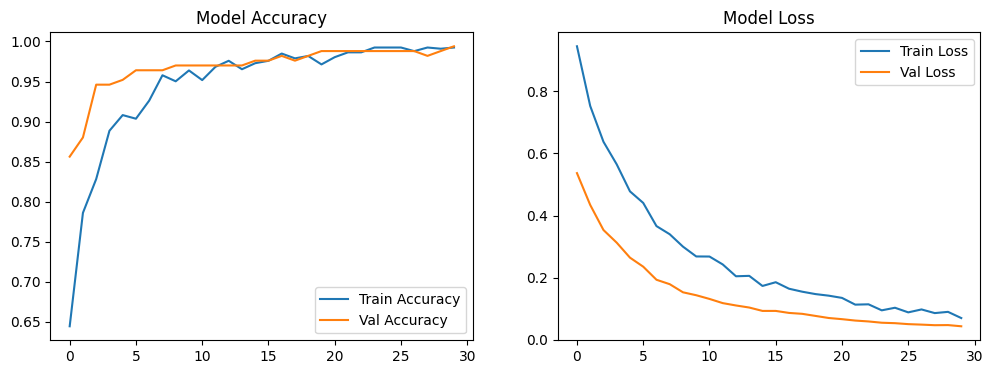

6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       123
   Parkinson       0.98      0.98      0.98        44

    accuracy                           0.99       167
   macro avg       0.98      0.98      0.98       167
weighted avg       0.99      0.99      0.99       167



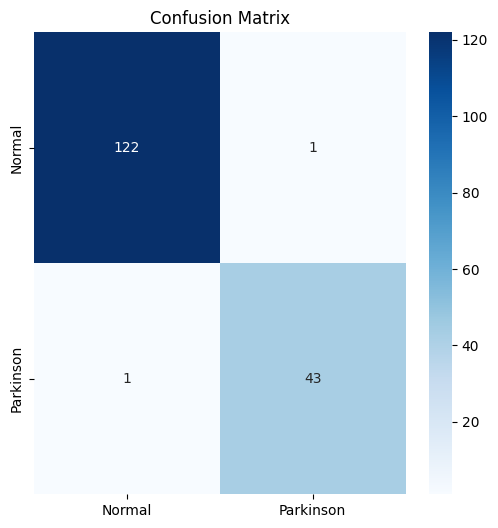

In [4]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

plot_history(history)

# Generate predictions
y_pred = model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_df['label'].values

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Parkinson']))

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Parkinson'],
            yticklabels=['Normal', 'Parkinson'])
plt.title('Confusion Matrix')
plt.show()


In [5]:
_, test_accuracy, _ = model.evaluate(test_ds)  # Ignore loss and AUC
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9844 - auc: 0.9999 - loss: 0.0478

Test Accuracy: 98.80%


In [6]:
import numpy as np
sample_images = test_df.sample(3)

for _, row in sample_images.iterrows():
    img = tf.keras.utils.load_img(row['path'], target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred_prob = model.predict(img_array, verbose=0)[0][0]
    pred_label = 'Parkinson' if pred_prob > 0.5 else 'Normal'
    
    print(f"\nImage: {Path(row['path']).name}")
    print(f"True Label: {'Parkinson' if row['label'] == 1 else 'Normal'}")
    print(f"Predicted: {pred_label} (score: {pred_prob:.4f})")
    print(f"Confidence: {max(pred_prob, 1-pred_prob):.1%}")


Image: ep2d_diff_3scan_trace_p2_TRACEW_DFC_052.png
True Label: Normal
Predicted: Normal (score: 0.1306)
Confidence: 86.9%

Image: Reg_-_sDW_SSh_SENSE_024.png
True Label: Parkinson
Predicted: Normal (score: 0.1290)
Confidence: 87.1%

Image: SWI_Images_024.png
True Label: Normal
Predicted: Normal (score: 0.1314)
Confidence: 86.9%


In [7]:
model.save('parkinson_model.h5') 